In [1]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import pickle 
from ply import write_ply

from utilities import *
from VoxelGrid import *
import os

from PIL import ImageFont
from PIL import ImageDraw 

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda' if torch.cuda.is_available() else 'cpu'



In [2]:
model="mic"
dataset= "../nerf_synthetic/" + model
focal, all_c2w, all_gt = get_data(dataset, "test")

LOAD DATA ../nerf_synthetic/mic/test


100%|█████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 57.59it/s]


In [9]:
class VoxelGridSphericalCarve(VoxelGridSpherical):
    def __init__(self, size=128, bound_w=1, init_op=3, num_harm=9):
        super().__init__(size, bound_w, num_harm)
        self.colors_sum = torch.zeros((self.opacities.shape[0], num_harm), device=device)
        with torch.no_grad():
            self.opacities[:] = init_op
            self.colors[:] = 0
    def subdivide(self):
        super().subdivide()
        self.colors_sum = torch.zeros_like(self.opacities)
    def carve(self, ordir_tuple, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long())
            mesh_coords[torch.logical_not(in_bounds)] = 0
            
            self.opacities[mesh_coords] = 0
            
    def color(self, ordir_tuple, pixels, N_points, inv_depth=1.2):
        with torch.no_grad():
            ori = ordir_tuple[0][:, None,:]

            # WARNING: Assuming constant distance
            distances = 8/(N_points-1)
            scatter_points = torch.linspace(0,10, N_points, device=device)[None, :]/inv_depth
            p = ori + scatter_points[:,:,None]*(ordir_tuple[1][:, None, :])    

            # extract valid indices
            inds_3d = torch.floor(self.descartes_to_indices(p))
            in_bounds = self.in_bounds_indices(inds_3d)
            # meshgrid coordinates
            mesh_coords = self.flatten_3d_indices(inds_3d.long()).long()
            mesh_coords[torch.logical_not(in_bounds)] = 0
            
            opacities = self.opacities[mesh_coords]*in_bounds.float() # not_in bounds: 0 opacity
            opacities = opacities*distances
            cumsum_opacities = torch.zeros_like(opacities, device=device)
            cumsum_opacities[:,1:] = torch.cumsum(opacities[:,:-1], 1)

            transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
            harmonics_base = self.view_harmonics(p[0,0])
            harmonics = harmonics_base[..., None, :]*pixels[:, :, None]
            self.colors[mesh_coords,:] += harmonics[:, None, :,: ]*transp_term[..., None, None]
            
            self.colors_sum[mesh_coords] += harmonics_base[None, None, :]*transp_term[..., None]
     
    
    
    



In [44]:

def create_rotation_jiggle_matrices(height, n=10):

    t = np.linspace(0,2*np.pi, n+1)[:-1]
    cust_centers = np.zeros((n,3))
    cust_centers[:,2] = height + np.cos(t)
    radius = np.sqrt(17-cust_centers[:,2]**2)
    cust_centers[:,0] = np.cos(t)*radius
    cust_centers[:,1] = np.sin(t)*radius
    view_angle = -np.arctan(height/radius)
    plt.plot(2*view_angle)
    plt.show()
    return [create_rotation_transformation_matrix(cust_centers[i], t[i], view_angle[i]) for i in range(n)]



In [51]:
cust_c2ws = create_rotation_matrices(1.5, -20, n=60)
red_fac=2
ordir_rays=[]
for c2w in cust_c2ws:
    ray_np = get_rays_np(800,800, focal, c2w)
    oris = ray_np[0][::red_fac,::red_fac]
    direct = ray_np[1][::red_fac,::red_fac] # direction. optimal fac:3
    ordir_rays.append((oris, direct))

In [54]:
VG=VoxelGridSphericalCarve(128, 1.4, 40, 4)
#VG.load(model+'_carve.obj')
#VG.load(model+'.obj')
VG.load("mic_sph.obj")
#VG.load('out_grid.obj')
#VG.save_pointcloud()

  0%|                                                                            | 0/60 [00:00<?, ?it/s]

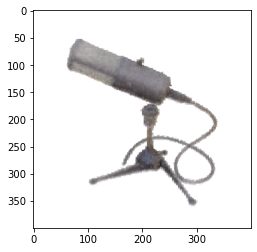

  2%|█▏                                                                  | 1/60 [00:01<01:29,  1.52s/it]

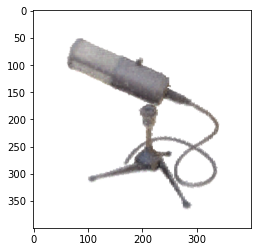

  3%|██▎                                                                 | 2/60 [00:02<01:22,  1.43s/it]

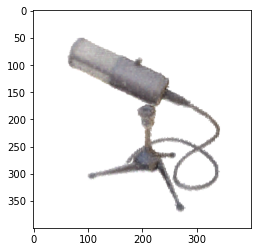

  5%|███▍                                                                | 3/60 [00:04<01:19,  1.40s/it]

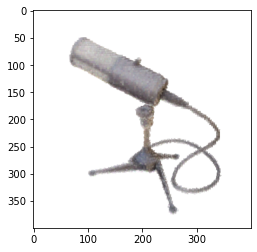

  7%|████▌                                                               | 4/60 [00:05<01:18,  1.41s/it]

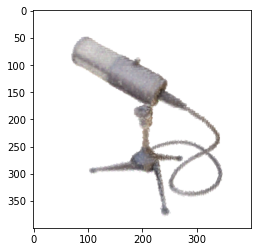

  8%|█████▋                                                              | 5/60 [00:07<01:16,  1.39s/it]

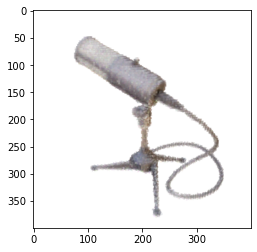

 10%|██████▊                                                             | 6/60 [00:08<01:14,  1.38s/it]

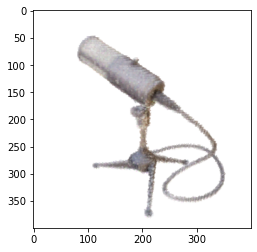

 12%|███████▉                                                            | 7/60 [00:09<01:13,  1.38s/it]

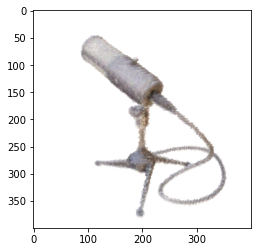

 13%|█████████                                                           | 8/60 [00:11<01:11,  1.38s/it]

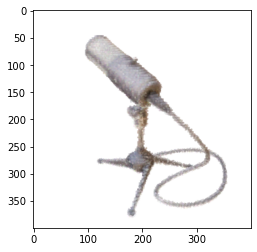

 15%|██████████▏                                                         | 9/60 [00:12<01:10,  1.37s/it]

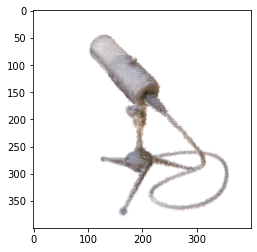

 17%|███████████▏                                                       | 10/60 [00:13<01:08,  1.37s/it]

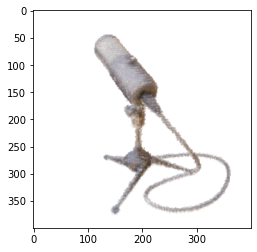

 18%|████████████▎                                                      | 11/60 [00:15<01:07,  1.37s/it]

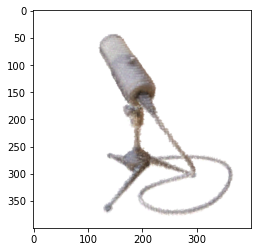

 20%|█████████████▍                                                     | 12/60 [00:16<01:05,  1.37s/it]

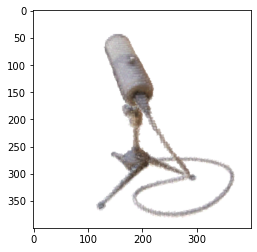

 22%|██████████████▌                                                    | 13/60 [00:17<01:04,  1.37s/it]

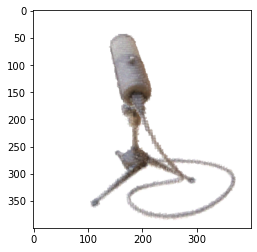

 23%|███████████████▋                                                   | 14/60 [00:19<01:03,  1.37s/it]

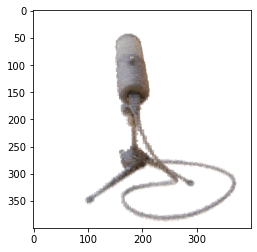

 25%|████████████████▊                                                  | 15/60 [00:20<01:01,  1.37s/it]

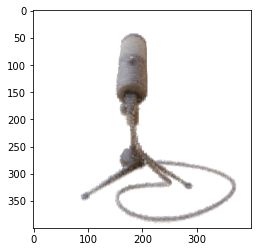

 27%|█████████████████▊                                                 | 16/60 [00:22<01:00,  1.37s/it]

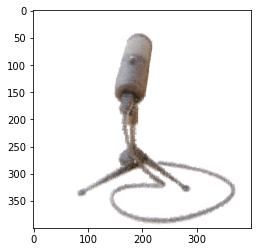

 28%|██████████████████▉                                                | 17/60 [00:23<00:59,  1.37s/it]

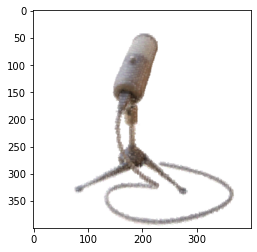

 30%|████████████████████                                               | 18/60 [00:24<00:57,  1.37s/it]

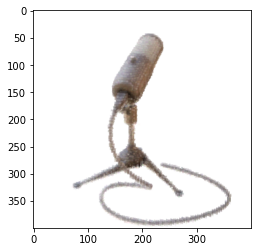

 32%|█████████████████████▏                                             | 19/60 [00:26<00:56,  1.37s/it]

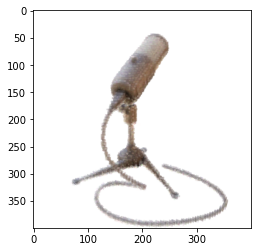

 33%|██████████████████████▎                                            | 20/60 [00:27<00:54,  1.37s/it]

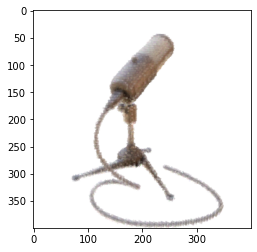

 35%|███████████████████████▍                                           | 21/60 [00:28<00:53,  1.37s/it]

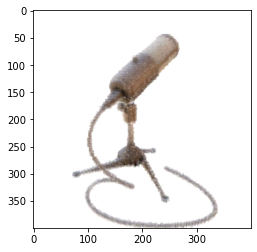

 37%|████████████████████████▌                                          | 22/60 [00:30<00:52,  1.39s/it]

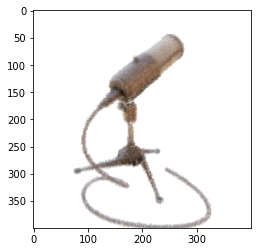

 38%|█████████████████████████▋                                         | 23/60 [00:31<00:51,  1.38s/it]

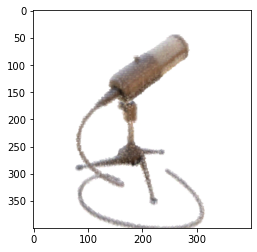

 40%|██████████████████████████▊                                        | 24/60 [00:33<00:49,  1.38s/it]

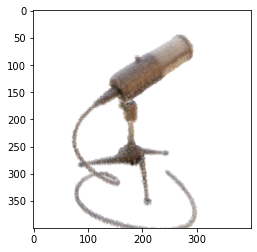

 42%|███████████████████████████▉                                       | 25/60 [00:34<00:48,  1.38s/it]

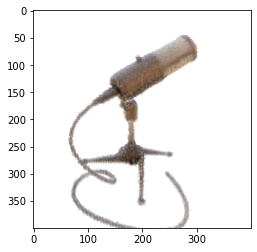

 43%|█████████████████████████████                                      | 26/60 [00:35<00:46,  1.37s/it]

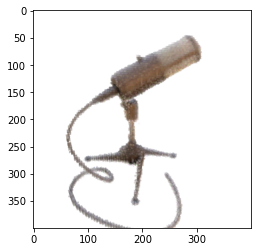

 45%|██████████████████████████████▏                                    | 27/60 [00:37<00:45,  1.37s/it]

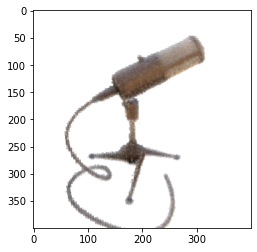

 47%|███████████████████████████████▎                                   | 28/60 [00:38<00:43,  1.37s/it]

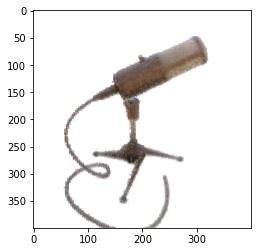

 48%|████████████████████████████████▍                                  | 29/60 [00:40<00:42,  1.37s/it]

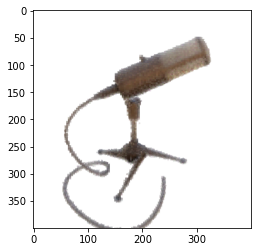

 50%|█████████████████████████████████▌                                 | 30/60 [00:41<00:41,  1.37s/it]

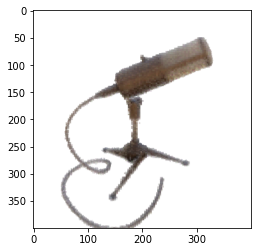

 52%|██████████████████████████████████▌                                | 31/60 [00:42<00:39,  1.37s/it]

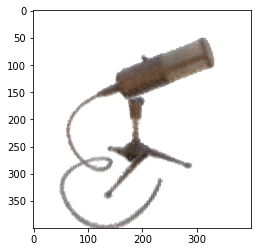

 53%|███████████████████████████████████▋                               | 32/60 [00:44<00:38,  1.37s/it]

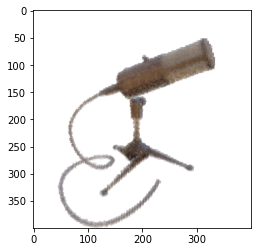

 55%|████████████████████████████████████▊                              | 33/60 [00:45<00:36,  1.37s/it]

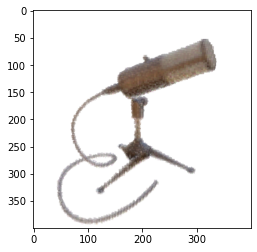

 57%|█████████████████████████████████████▉                             | 34/60 [00:46<00:35,  1.37s/it]

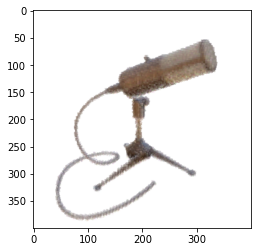

 58%|███████████████████████████████████████                            | 35/60 [00:48<00:34,  1.36s/it]

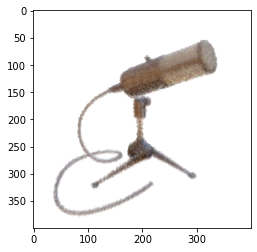

 60%|████████████████████████████████████████▏                          | 36/60 [00:49<00:32,  1.36s/it]

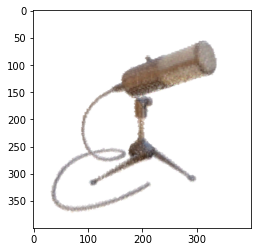

 62%|█████████████████████████████████████████▎                         | 37/60 [00:50<00:31,  1.36s/it]

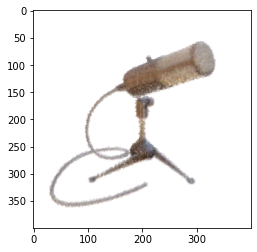

 63%|██████████████████████████████████████████▍                        | 38/60 [00:52<00:29,  1.36s/it]

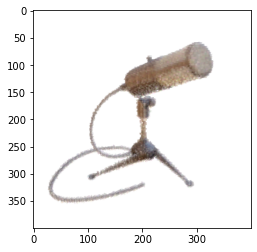

 65%|███████████████████████████████████████████▌                       | 39/60 [00:53<00:28,  1.36s/it]

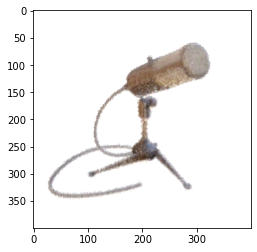

 67%|████████████████████████████████████████████▋                      | 40/60 [00:55<00:27,  1.38s/it]

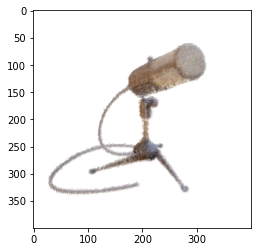

 68%|█████████████████████████████████████████████▊                     | 41/60 [00:56<00:26,  1.37s/it]

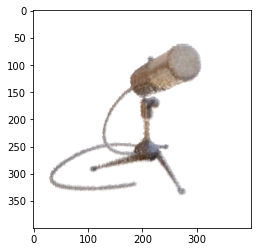

 70%|██████████████████████████████████████████████▉                    | 42/60 [00:57<00:24,  1.37s/it]

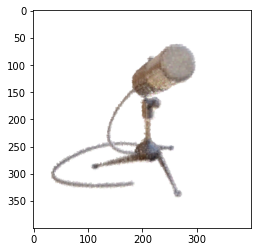

 72%|████████████████████████████████████████████████                   | 43/60 [00:59<00:23,  1.37s/it]

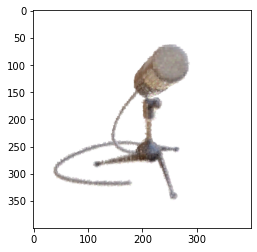

 73%|█████████████████████████████████████████████████▏                 | 44/60 [01:00<00:21,  1.37s/it]

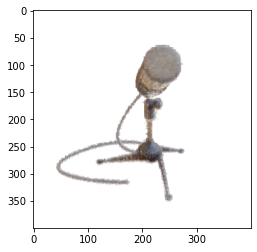

 75%|██████████████████████████████████████████████████▎                | 45/60 [01:01<00:20,  1.37s/it]

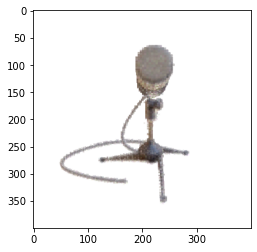

 77%|███████████████████████████████████████████████████▎               | 46/60 [01:03<00:19,  1.37s/it]

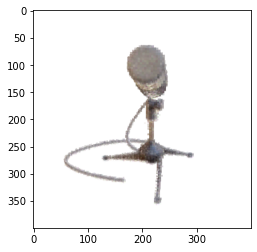

 78%|████████████████████████████████████████████████████▍              | 47/60 [01:04<00:17,  1.37s/it]

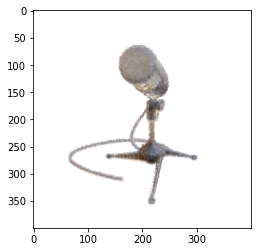

 80%|█████████████████████████████████████████████████████▌             | 48/60 [01:05<00:16,  1.37s/it]

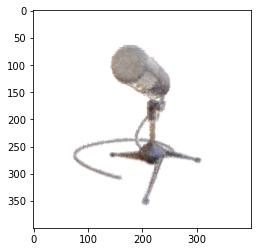

 82%|██████████████████████████████████████████████████████▋            | 49/60 [01:07<00:15,  1.36s/it]

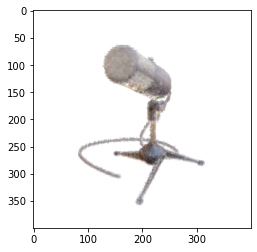

 83%|███████████████████████████████████████████████████████▊           | 50/60 [01:08<00:13,  1.36s/it]

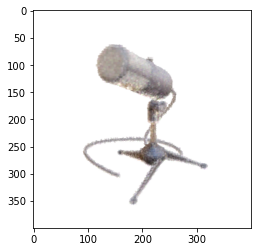

 85%|████████████████████████████████████████████████████████▉          | 51/60 [01:10<00:12,  1.36s/it]

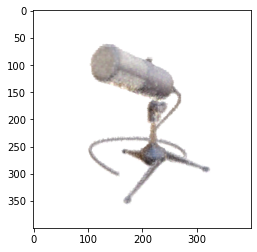

 87%|██████████████████████████████████████████████████████████         | 52/60 [01:11<00:10,  1.36s/it]

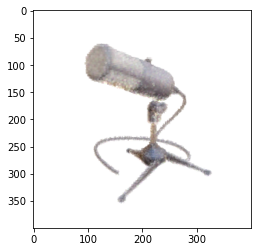

 88%|███████████████████████████████████████████████████████████▏       | 53/60 [01:12<00:09,  1.36s/it]

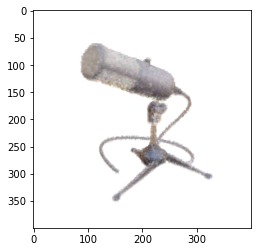

 90%|████████████████████████████████████████████████████████████▎      | 54/60 [01:14<00:08,  1.36s/it]

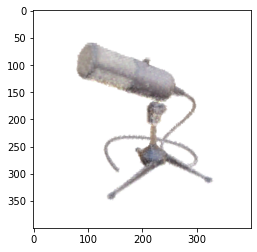

 92%|█████████████████████████████████████████████████████████████▍     | 55/60 [01:15<00:06,  1.36s/it]

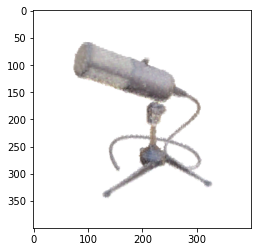

 93%|██████████████████████████████████████████████████████████████▌    | 56/60 [01:16<00:05,  1.36s/it]

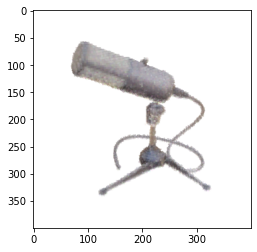

 95%|███████████████████████████████████████████████████████████████▋   | 57/60 [01:18<00:04,  1.36s/it]

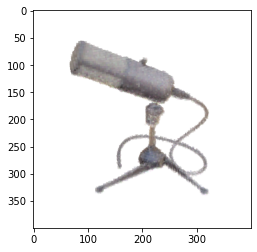

 97%|████████████████████████████████████████████████████████████████▊  | 58/60 [01:19<00:02,  1.38s/it]

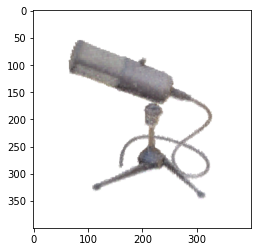

 98%|█████████████████████████████████████████████████████████████████▉ | 59/60 [01:20<00:01,  1.37s/it]

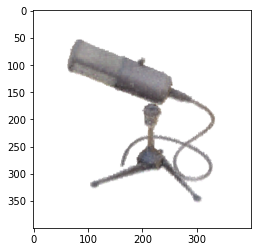

100%|███████████████████████████████████████████████████████████████████| 60/60 [01:22<00:00,  1.37s/it]


In [55]:
imgs=[]
for image_ind in tqdm(range(len(cust_c2ws))):
    with torch.no_grad():
        new_im = VG.render_large_image_from_rays(ordir_rays[image_ind],(900, 1.2))
        plt.imshow(new_im)
        plt.show()
        imgs.append(np.uint8(255*new_im))

In [56]:
imageio.mimwrite('exports/mic4b.gif', imgs,  format='GIF', duration=0.08)

In [7]:
plt.imsave('exports/carve/lego.png', imgs[1])

# View

In [5]:
red = 4
disp_ims, disp_rays = reduce_data(all_c2w, all_gt, focal, red)
disp_im_w = disp_ims[0].shape[0]
print(disp_im_w)

200


In [61]:
dataset  = "mic"
test_focal, test_c2w, test_gt = get_data("../nerf_synthetic/"+dataset, "test")

LOAD DATA ../nerf_synthetic/mic/test


100%|█████████████████████████████████████████████████████████████████| 200/200 [00:03<00:00, 61.28it/s]


In [62]:
red = 8
disp_ims_test, disp_rays_test = reduce_data(test_c2w, test_gt,test_focal, red)
disp_im_w = disp_ims_test[0].shape[0]

In [63]:
compute_psnr(VG, disp_rays_test, disp_ims_test, 900)

100%|█████████████████████████████████████████████████████████████████| 200/200 [00:16<00:00, 12.16it/s]


21.49602184983927

In [64]:
image_ind=np.random.randint(99)
print(image_ind)
im_ref = disp_ims[image_ind]
new_im = VG.render_large_image_from_rays(disp_rays[image_ind],(900,1.2), 500)
plt.imshow(im_ref)
plt.show()
plt.imshow(new_im)
plt.show()

27


NameError: name 'disp_ims' is not defined

In [29]:
VG=VoxelGridSphericalCarve(128,1)
m = torch.arange(VG.size**3)

x = m%VG.size 
y = (m//VG.size)%VG.size
z = (m//VG.size//VG.size)%VG.size
radius = (x-VG.size/2)**2+(y-VG.size/2)**2+(z-VG.size/2)**2
with torch.no_grad():
    VG.opacities[torch.sqrt(radius)>VG.size/2] = 0
    VG.colors[:] = torch.rand((3,9))/2